In [1]:
import gensim
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, Word2VecModel

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np

In [2]:
PATH = './data/'
# spark = SparkSession.builder.master("local").appName("WikiParse").getOrCreate()
conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '6G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '10G'))
sc = SparkContext(conf=conf)

### Save pyspark Word2Vec model to gensim format

In [3]:
def save_model(w2v_model, file_name):
    vectors = w2v_model.getVectors()
    size = len(vectors.first()['vector'])
    amount = vectors.count()

    vectors_collection = vectors.collect()

    f = open(file_name, 'w')

    f.write('{} {}\n'.format(amount, size))

    for row in vectors_collection:
        vec_str = ' '.join([ str(np.round(x, 5)) for x in row['vector']])
        f.write(row['word'] + ' ' + vec_str + '\n')

    f.close()


custom_models = dict()

In [4]:
def save_model_for_gensim(n):
    custom_model = Word2VecModel.load(PATH + "/w2v/word2vec_{}".format(n))
    print('Loaded Word2VecModel: {}'.format(n))
    save_model(custom_model, PATH + 'custom.embeddings.{}'.format(n))
    print('Saved: {}'.format(n))


In [5]:
# save_model_for_gensim(30)

### Read model by gensim

In [6]:
eta_model = gensim.models.KeyedVectors.load_word2vec_format(PATH+\
                                                            'ubercorpus.lowercased.tokenized.word2vec.300d.bz2')

/home/serhii/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
w2v_model_nums = [1,3,5,7,9,11,15,24,26,30]

In [8]:
for load in w2v_model_nums:
    custom_model = gensim.models.KeyedVectors.load_word2vec_format(PATH + 'custom.embeddings.{}'.format(load))
    print('Loaded Gensim: {}'.format(load))
    custom_models[load] = custom_model

/home/serhii/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loaded Gensim: 1
Loaded Gensim: 3
Loaded Gensim: 5
Loaded Gensim: 7
Loaded Gensim: 9
Loaded Gensim: 11
Loaded Gensim: 15
Loaded Gensim: 24
Loaded Gensim: 26
Loaded Gensim: 30


### Evaluate models

In [9]:
def test_model(model, num = 1000):
    
    total_num = 0
    counter = 0
    
    start = 21000    
    s = 2000

    with open(PATH + 'test_vocabulary.txt') as f:
        lines = f.readlines()
        
#         test_arr = lines[s:s+num] + lines[start:]
        test_arr = lines

        for line in test_arr:
            test_words = line[:-1].lower().split('\t')
            if test_words[0][0] == ':':
                continue

            w1, w2, w3, w4 = tuple(test_words)

            if w1 in model and w2 in model and w3 in model and w4 in model:
                
                total_num += 1

                result = model.most_similar(positive=[w1, w4], negative=[w3])

                for r in result:
                    if r[0] == w2:
                        counter += 1
                        break
                    
    return np.round(counter / total_num, 4), counter, total_num, len(test_arr)

acc_result = []

for test in w2v_model_nums:
    result = test_model(custom_models[test])
    acc_result.append((test, result))
    print((test, result))

(1, (0.2482, 2685, 10817, 23982))
(3, (0.3348, 4173, 12463, 23982))
(5, (0.3366, 4223, 12545, 23982))
(7, (0.3426, 4454, 13001, 23982))
(9, (0.3503, 4648, 13268, 23982))
(11, (0.3536, 4767, 13483, 23982))
(15, (0.3698, 5169, 13978, 23982))
(24, (0.3377, 4969, 14715, 23982))
(26, (0.3537, 5235, 14799, 23982))
(30, (0.3368, 5118, 15194, 23982))


In [10]:
acc_eta = test_model(eta_model)
acc_eta

(0.4927, 7772, 15773, 23982)

### Plot results

In [11]:
g_data = {
    'models': [],
    'acc': [],
    'abs_acc': [],
    'color': [],
    'vocab_size': [],
    'missed_words': []
}

m_counter = 1

for acc in acc_result:
    g_data['models'].append(m_counter)
    g_data['acc'].append(acc[1][0])
    g_data['abs_acc'].append(acc[1][1]/acc[1][3])
    g_data['vocab_size'].append(len(custom_models[acc[0]].wv.vocab))
    g_data['missed_words'].append( acc[1][3] - acc[1][2] )
    
    g_data['color'].append('#0000FF')
    m_counter+=1
    
g_data['acc'].append(acc_eta[0])
g_data['abs_acc'].append(acc_eta[1]/acc_eta[3])
g_data['models'].append(m_counter)
g_data['color'].append('#FF0000')
g_data['vocab_size'].append(len(eta_model.wv.vocab))
g_data['missed_words'].append(acc_eta[3] - acc_eta[2])

/home/serhii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/home/serhii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [13]:
def plot_result(field, title, xlabel, ylabel):
    plt.figure(figsize=(10,10))
    plt.vlines(g_data['models'], ymin =0, ymax = g_data[field])
    plt.scatter(g_data['models'], g_data[field], color=g_data['color'], s=100)

    xticks = [str(w2v_m) + '0k' for w2v_m in w2v_model_nums]
    xticks.append('lang-ua')

    plt.xticks(g_data['models'], xticks)

    plt.title(title)

    plt.ylabel(ylabel)

    plt.xlabel(xlabel)

    plt.show()
    

### Model accuracy depending on the number of articles

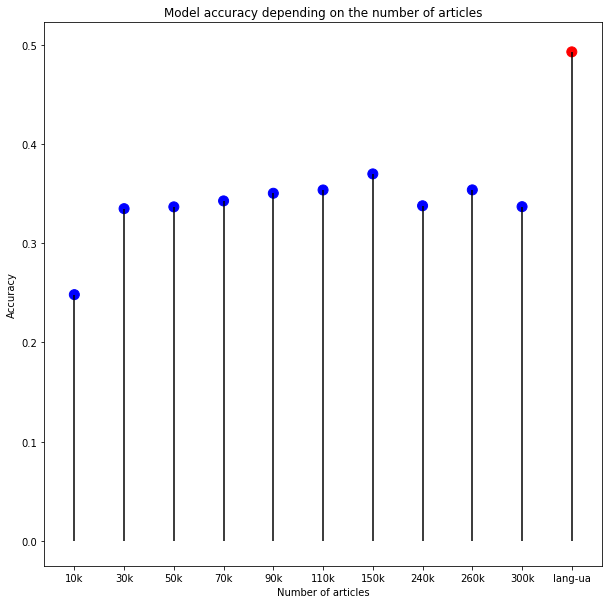

In [14]:
plot_result(
    'acc',
    'Model accuracy depending on the number of articles',
    'Number of articles',
    'Accuracy'
)

### Absolute accuracy is a relation between correct result to whole dataset. In the previous case it is a relation to words in the vocabulary.

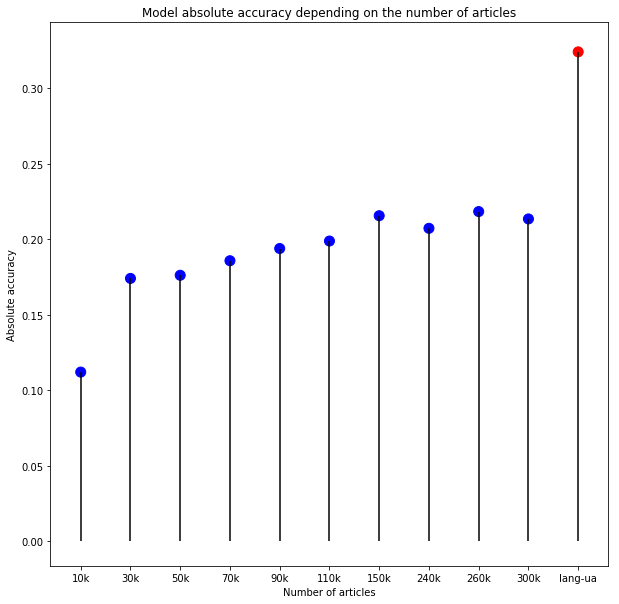

In [15]:
plot_result(
    'abs_acc',
    'Model absolute accuracy depending on the number of articles',
    'Number of articles',
    'Absolute accuracy'
)

### Model vocabulary size

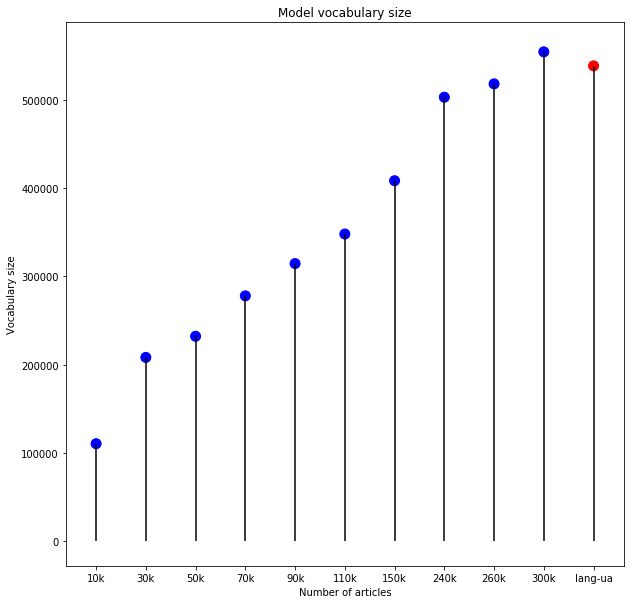

In [16]:
plot_result(
    'vocab_size',
    'Model vocabulary size',
    'Number of articles',
    'Vocabulary size'
)

### Model word absence

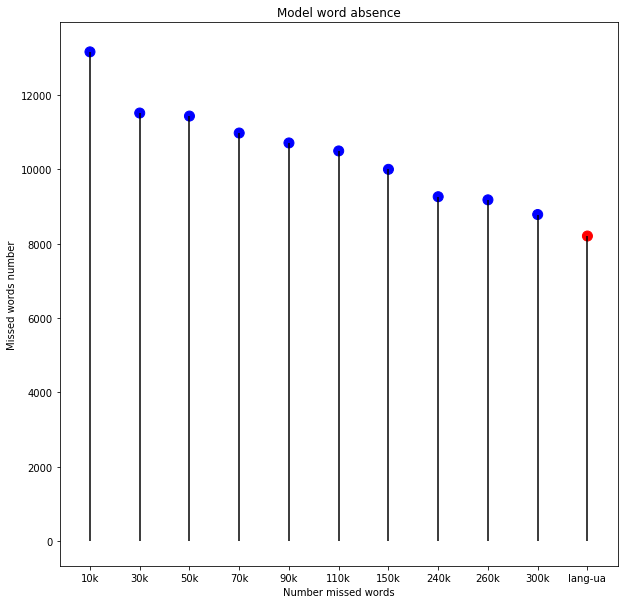

In [17]:
plot_result(
    'missed_words',
    'Model word absence',
    'Number missed words',
    'Missed words number'
)